In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.legendre.setup_legendre import SimulationSetupLegendre
from operators.poisson_solver import gmres_solver
from operators.legendre.legendre_operators import xi_legendre, charge_density_legendre, total_mass_legendre, total_momentum_legendre, total_energy_k_legendre

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Enable LaTeX rendering
matplotlib.rcParams['text.usetex'] = True

# Legendre bump-on-tail instability

In [80]:
setup = SimulationSetupLegendre(Nx=101,
                                Nv_e=512,
                                epsilon=1e-2,
                                v_a=-4,
                                v_b=4,
                                alpha_e1=np.sqrt(2),
                                alpha_e2=np.sqrt(2),
                                u_e1=0,
                                u_e2=0,
                                n0_e1=1,
                                n0_e2=0,
                                k0=0.5,
                                L=4 * np.pi,
                                dt=1e-2,
                                Nv_int=5000,
                                T0=0,
                                T=35,
                                nu=1,
                                gamma=0.5)

In [81]:
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx+1, endpoint=True)
v_ = np.linspace(setup.v_a, setup.v_b, 15000, endpoint=True)

# simulation results

In [82]:
skip = 1
# load the simulation results
# save results
sol_midpoint_u = np.load("../../data/legendre/two_stream/sol_u_Nv_" + str(setup.Nv_e) + "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../../data/legendre/two_stream/sol_t_Nv_" + str(setup.Nv_e) + "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

dt = 0.01 * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(51712, 3501)
(3501,)


In [83]:
runtime = np.load("../../data/legendre/two_stream/sol_runtime_Nv_" + str(setup.Nv_e) + "_Nx_" + str(setup.Nx)
            + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
runtime

array([43199.089407  , 12055.86557698])

In [84]:
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

In [85]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((setup.Nv_e,  setup.Nx + 1, len(sol_midpoint_t)))

# unwind the flattening to solve the Vlasov-Poisson system
# electrons
state_e_midpoint[:, :-1, :] = np.reshape(sol_midpoint_u, (setup.Nv_e, setup.Nx, len(sol_midpoint_t)))
# periodicity enforced
state_e_midpoint[:, -1, :] = state_e_midpoint[:, 0, :]

for ii in np.arange(0, len(sol_midpoint_t)):
    # solve Poisson's equation to obtain an electric field
    rho = charge_density_legendre(q_e=setup.q_e, 
                                  q_i=setup.q_i,
                                  C0_e=state_e_midpoint[0, :setup.Nx, ii], 
                                  C0_i=np.ones(setup.Nx)/(setup.v_b - setup.v_a),
                                  v_a=setup.v_a, v_b=setup.v_b)
    
    
    E_midpoint[:-1, ii] = gmres_solver(rhs=rho, D=setup.D, D_inv=setup.D_inv, a_tol=1e-12, r_tol=1e-12)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

In [86]:
    rho = charge_density_legendre(q_e=setup.q_e, 
                                  q_i=setup.q_i,
                                  C0_e=state_e_midpoint[0, :-1, 0], 
                                  C0_i=np.ones(setup.Nx)/(setup.v_b - setup.v_a),
                                  v_a=setup.v_a, v_b=setup.v_b)

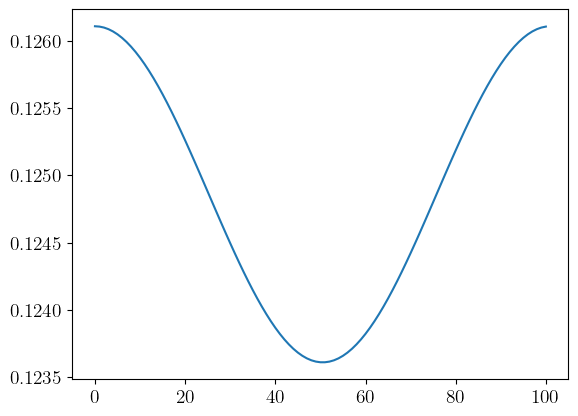

In [87]:
plt.plot(state_e_midpoint[0, :setup.Nx, 0])

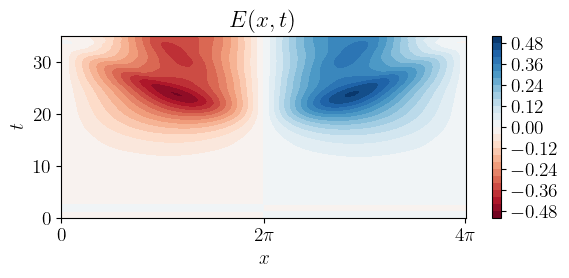

In [88]:
# plot the electric field
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu", levels=30)
cbar = fig.colorbar(pos)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, 2*np.pi, 4*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$2\pi$", r"$4\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

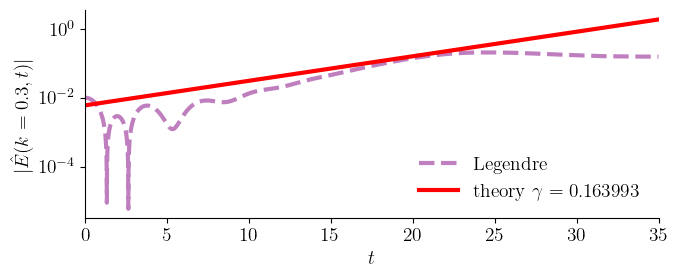

In [89]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, np.abs(np.fft.fft(E_midpoint, axis=0, norm="forward")[1, :]), "--", c="purple", alpha=0.5, linewidth=3, label="Legendre") 
ax.plot(sol_midpoint_t, 6e-3*np.exp(0.163993367317754*sol_midpoint_t), linewidth=3, color="red", label=r"theory $\gamma = 0.163993$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(k=0.3, t)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
#ax.set_ylim(1e-5, 1e-2)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=14, loc='lower right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../../figures/legendre/bump_on_tail/bump_on_tail_growth_rate_legendre.png", dpi=300)

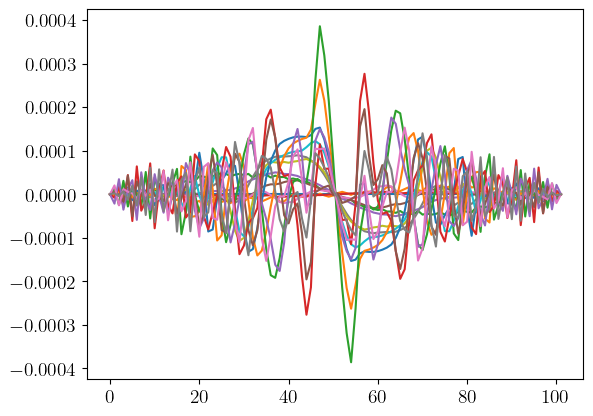

In [90]:
_ = plt.plot(state_e_midpoint[-1, :, ::200])

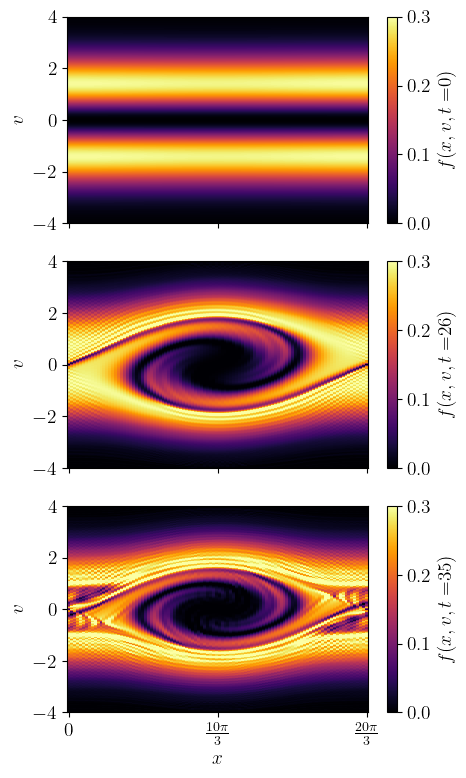

In [91]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=3, figsize=(5, 8), sharex=True)
for tt, ii in enumerate([0, int(3*len(sol_midpoint_t)//4), -1]):
    ii = int(ii)
    distribution = np.zeros((len(x), len(v_)))
    for jj in range(setup.Nv_e):
        distribution += np.outer(state_e_midpoint[jj, :, ii], xi_legendre(v=v_, v_b=setup.v_b, v_a=setup.v_a, n=jj))
    pos = ax[tt].pcolormesh(x, v_, distribution.T, vmin=0, vmax=0.3, cmap="inferno")
    ax[tt].set_ylabel("$v$")
    cbar = fig.colorbar(pos)
    cbar.ax.set_ylabel('$f(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
    cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])
    #ax[tt].set_title("$f(x, v, t=$" + str(int(sol_midpoint_t[ii])) + ")")

ax[tt].set_xlabel("$x$")
ax[tt].set_xticks([0, 2*np.pi, 4*np.pi])
ax[tt].set_xticklabels([r"0", r"$\frac{10\pi}{3}$", r"$\frac{20\pi}{3}$"])
plt.tight_layout()
plt.savefig("../../figures/legendre/two_stream/two_stream_evolution_legendre_" + str(setup.Nv_e) + ".png", dpi=600)

In [1]:
np.save("../../data/legendre/two_stream/E_field_" + str(setup.Nv_e) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy", E_midpoint)

NameError: name 'np' is not defined

In [ ]:
np.save("../../data/legendre/two_stream/distribution_t_35_" + str(setup.Nv_e)+
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy", distribution)

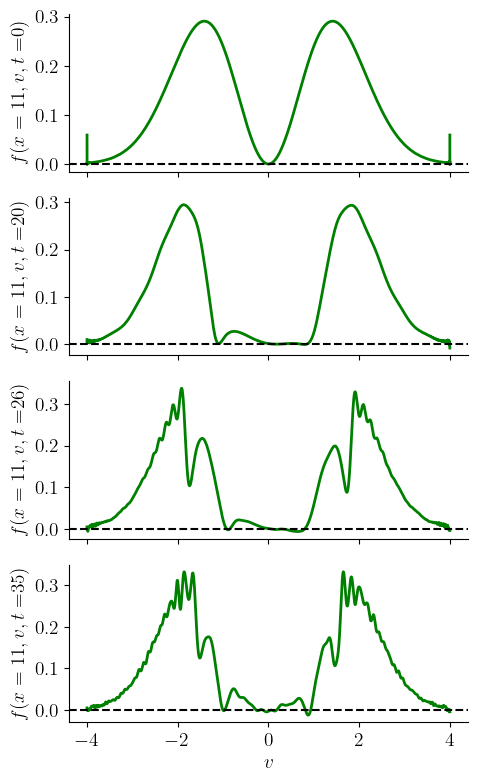

In [94]:
fig, ax = plt.subplots(nrows=4, figsize=(5, 8), sharex=True)
for tt, ii in enumerate([0, 2000, int(3*len(sol_midpoint_t)//4), -1]):
    ii = int(ii)
    distribution_L = np.zeros((len(x), len(v_)))
    for jj in range(setup.Nv_e):
        distribution_L += np.outer(state_e_midpoint[jj, :, ii], xi_legendre(v=v_, v_b=setup.v_b, v_a=setup.v_a, n=jj))
    _ = ax[tt].plot(v_, distribution_L[55, :], color="green", ls="-", linewidth=2)
    ax[tt].spines['right'].set_visible(False)
    ax[tt].spines['top'].set_visible(False)
    ax[tt].set_ylabel("$f(x=11, v, t=$" + str(int(sol_midpoint_t[ii])) + ")")
    ax[tt].axhline(0, color="black", ls="--")

ax[-1].set_xlabel("$v$")
plt.tight_layout()
plt.savefig("../../figures/legendre/two_stream/two_stream_slice_legendre.png", dpi=300)

# conservation laws: mass, momentum, and energy

### mass conservation

In [19]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass_legendre(state=state_e_midpoint[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx)\
                        +total_mass_legendre(state=state_i_midpoint[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx)

NameError: name 'state_i_midpoint' is not defined

In [ ]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
plt.tight_layout()

### momentum conservation

In [ ]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum_legendre(state=state_e_midpoint[:, :-1, ii],
                                                    v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)\
                            +total_momentum_legendre(state=state_i_midpoint[:, :-1, ii], 
                                                     v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_i)

In [ ]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlim(setup.T0, setup.T)
ax.set_xlabel("$t$")
plt.tight_layout()

### energy conservation

In [ ]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k_legendre(state=state_e_midpoint[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)\
                           +total_energy_k_legendre(state=state_i_midpoint[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_i)
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

In [ ]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

In [ ]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy", ls="--", linewidth=2, color="blue")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy", linewidth=2, color="red")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("$t$")
_ = ax.set_ylabel(r"$\Delta E$")

### conservation summary

In [ ]:
# plot the analytic and numerical conservation properties
skip = 5

fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::skip], np.abs(mass_midpoint-mass_midpoint[0])[::skip], s=30, color="black", label=r"mass $\mathcal{M}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(momentum_midpoint-momentum_midpoint[0])[::skip], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::skip], ">", color="purple", label=r"energy $\mathcal{E}(t)$")

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
legend = ax.legend(ncols=3, fontsize=14, loc='upper center')
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.tight_layout()